# 📈 Single-Target Statistical Arbitrage Tutorial

This notebook demonstrates how to build and backtest a single-target quantitative trading strategy using walk-forward validation.

## Learning Objectives

1. Load and prepare financial time-series data
2. Implement walk-forward backtesting methodology
3. Test multiple position sizing strategies
4. Evaluate performance with professional benchmarks
5. Generate publication-quality tear sheets

## 1. Setup and Imports

In [1]:
# Add project source to path
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import simulation modules
from single_target_simulator import (
    load_and_prepare_data,
    Simulate,
    sim_stats_single_target,
    SingleTargetBenchmarkManager,
    SingleTargetBenchmarkConfig,
    BinaryPositionSizer,
    QuartilePositionSizer,
    ProportionalPositionSizer
)

# Import plotting utilities
from plotting_utils import create_professional_tear_sheet

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso

print("✅ Imports successful!")

✅ Imports successful!


## 2. Configuration and Data Loading

We'll predict SPY (S&P 500 ETF) returns using sector ETFs as features.

In [2]:
# Simulation configuration
TARGET_ETF = 'SPY'
FEATURE_ETFS = ['XLK', 'XLF', 'XLV', 'XLY', 'XLP', 'XLE']  # Sector ETFs
START_DATE = '2020-01-01'
WINDOW_SIZE = 200  # Minimum training window
WINDOW_TYPE = 'expanding'  # Growing window over time

print(f"📊 Configuration:")
print(f"  Target ETF: {TARGET_ETF}")
print(f"  Feature ETFs: {FEATURE_ETFS}")
print(f"  Start Date: {START_DATE}")
print(f"  Window Type: {WINDOW_TYPE}")
print(f"  Window Size: {WINDOW_SIZE}")

📊 Configuration:
  Target ETF: SPY
  Feature ETFs: ['XLK', 'XLF', 'XLV', 'XLY', 'XLP', 'XLE']
  Start Date: 2020-01-01
  Window Type: expanding
  Window Size: 200


In [3]:
# Load and prepare data
# Note: etf_list must include ALL ETFs (features + target)
print("📥 Loading ETF data...")
ALL_ETFS = FEATURE_ETFS + [TARGET_ETF]
X, y, all_returns = load_and_prepare_data(
    etf_list=ALL_ETFS,
    target_etf=TARGET_ETF,
    start_date=START_DATE
)

print(f"\n✅ Data loaded successfully!")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")
print(f"  Date range: {X.index[0].date()} to {X.index[-1].date()}")
print(f"\n📈 First few rows of features:")
display(X.head())

📥 Loading ETF data...


[*********************100%***********************]  7 of 7 completed

Data preparation complete.

✅ Data loaded successfully!
  Features (X): (1516, 6)
  Target (y): (1516,)
  Date range: 2020-01-03 to 2026-01-14

📈 First few rows of features:


Ticker,XLE,XLF,XLK,XLP,XLV,XLY
teo,,,,,,
2020-01-03 21:00:00,-0.002976,-0.010675,-0.011307,-0.001601,-0.008753,-0.008547
2020-01-06 21:00:00,0.007751,-0.000651,0.002380,0.002082,0.006204,0.002778
2020-01-07 21:00:00,-0.002632,-0.006529,-0.000433,-0.007709,-0.001965,-0.001586
2020-01-08 21:00:00,-0.016609,0.006529,0.010644,0.003701,0.006470,0.003012
2020-01-09 21:00:00,0.007342,0.006164,0.011272,0.007043,0.004291,0.005288


## 3. Initialize Benchmarks

Professional benchmarks help us evaluate if our strategy adds value.

In [4]:
# Initialize benchmark manager
benchmark_config = SingleTargetBenchmarkConfig()
benchmark_manager = SingleTargetBenchmarkManager(
    target_etf=TARGET_ETF,
    feature_etfs=FEATURE_ETFS,
    config=benchmark_config
)

print("📊 Available Benchmarks:")
for name in benchmark_manager.benchmarks.keys():
    print(f"  - {name}")

📊 Available Benchmarks:
  - buy_and_hold
  - zero_return


## 4. Define Position Sizing Strategies

Position sizing determines how we translate model predictions into portfolio leverage.

In [5]:
# Define position sizing strategies
position_strategies = [
    ('Binary', BinaryPositionSizer(short_position=-1.0, long_position=1.0)),
    ('Proportional', ProportionalPositionSizer(max_position=2.0, min_position=0.0)),
]

print("📊 Position Sizing Strategies:")
for name, sizer in position_strategies:
    print(f"  - {name}: {sizer}")

📊 Position Sizing Strategies:
  - Binary: <single_target_simulator.BinaryPositionSizer object at 0x13613b380>
  - Proportional: <single_target_simulator.ProportionalPositionSizer object at 0x13613b4d0>


## 5. Run Walk-Forward Simulations

We'll test multiple model and position sizing combinations.

In [6]:
# Define model configurations
models_to_test = [
    {
        'name': 'ridge',
        'pipe_steps': [('scaler', StandardScaler()), ('model', Ridge())],
        'param_grid': {'model__alpha': 1.0}
    },
    {
        'name': 'lasso',
        'pipe_steps': [('scaler', StandardScaler()), ('model', Lasso())],
        'param_grid': {'model__alpha': 0.1}
    }
]

print(f"🔄 Running {len(models_to_test) * len(position_strategies)} simulation combinations...\n")

🔄 Running 4 simulation combinations...



In [7]:
# Run simulations
regout_list = []
sweep_tags = []
metadata_list = []

for model_config in models_to_test:
    for pos_name, pos_sizer in position_strategies:
        tag = f"{model_config['name']}_{pos_name}"
        
        print(f"\n{'='*60}")
        print(f"🔄 Running: {tag}")
        print(f"{'='*60}")
        
        # Run simulation
        regout, metadata = Simulate(
            X=X,
            y=y,
            window_size=WINDOW_SIZE,
            window_type=WINDOW_TYPE,
            pipe_steps=model_config['pipe_steps'],
            param_grid=model_config['param_grid'],
            tag=tag,
            etf_symbols=FEATURE_ETFS,
            target_etf=TARGET_ETF,
            start_date=START_DATE
        )
        
        # Apply position sizing
        positions = pos_sizer.calculate_position(regout['prediction'])
        regout['leverage'] = positions
        regout['perf_ret'] = positions * y.loc[regout.index]
        
        regout_list.append(regout)
        sweep_tags.append(tag)
        metadata_list.append(metadata)
        
        print(f"✅ Completed {tag}")

print(f"\n\n🎉 All {len(regout_list)} simulations completed!")


🔄 Running: ridge_Binary
Starting simulation for tag: ridge_Binary...
  ... processing date 2020-10-19 (0/1316)
  ... processing date 2021-10-19 (252/1316)
  ... processing date 2022-10-19 (504/1316)
  ... processing date 2023-10-20 (756/1316)
  ... processing date 2024-10-22 (1008/1316)
  ... processing date 2025-10-24 (1260/1316)
Simulation for ridge_Binary complete.
✅ Completed ridge_Binary

🔄 Running: ridge_Proportional
Starting simulation for tag: ridge_Proportional...
  ... processing date 2020-10-19 (0/1316)
  ... processing date 2021-10-19 (252/1316)
  ... processing date 2022-10-19 (504/1316)
  ... processing date 2023-10-20 (756/1316)
  ... processing date 2024-10-22 (1008/1316)
  ... processing date 2025-10-24 (1260/1316)
Simulation for ridge_Proportional complete.
✅ Completed ridge_Proportional

🔄 Running: lasso_Binary
Starting simulation for tag: lasso_Binary...
  ... processing date 2020-10-19 (0/1316)
  ... processing date 2021-10-19 (252/1316)
  ... processing date 2022

## 6. Calculate Performance Statistics

Compare all strategies against professional benchmarks.

In [8]:
# Calculate statistics
print("📊 Calculating performance statistics...\n")

stats_df, results = sim_stats_single_target(
    regout_list=regout_list,
    sweep_tags=sweep_tags,
    author='Tutorial',
    target_etf=TARGET_ETF,
    feature_etfs=FEATURE_ETFS,
    benchmark_manager=benchmark_manager,
    metadata_list=metadata_list
)

print("✅ Statistics calculated!\n")
print("📈 Performance Summary:")
print("="*80)
display(stats_df)

INFO:single_target_simulator:Calculating statistics for 4 strategies


📊 Calculating performance statistics...

SIMULATION RANGE: from 2020-10-19 20:00:00 to 2026-01-14 21:00:00


[*********************100%***********************]  7 of 7 completed
ERROR:single_target_simulator:Error calculating statistics for ridge_Binary: 'DataFrame' object has no attribute 'actual'
ERROR:single_target_simulator:Error calculating statistics for ridge_Proportional: 'DataFrame' object has no attribute 'actual'
ERROR:single_target_simulator:Error calculating statistics for lasso_Binary: 'DataFrame' object has no attribute 'actual'
ERROR:single_target_simulator:Error calculating statistics for lasso_Proportional: 'DataFrame' object has no attribute 'actual'


Data preparation complete.
✅ Statistics calculated!

📈 Performance Summary:


,ridge_Binary,ridge_Proportional,lasso_Binary,lasso_Proportional
metric,,,,
return,0.051826,0.198141,0.160690,0.118652
stdev,0.170010,0.201369,0.169781,0.172594
sharpe,0.304839,0.983969,0.946454,0.687465
max_drawdown,-0.221410,-0.289672,-0.244964,-0.316768
avg_leverage,0.180851,1.171757,1.000000,1.086852
leverage_1_return,0.286566,0.169097,0.160690,0.109171
pos_prediction_ratio,0.590426,0.590426,1.000000,1.000000
complexity_score,2.000000,2.000000,2.000000,2.000000
complexity_adj_return,NaN,NaN,NaN,NaN


## 7. Identify Best Strategy

Find the strategy with the highest Sharpe ratio.

In [9]:
# Find best strategy by Sharpe ratio
stats_df = stats_df.T
if 'sharpe' in stats_df.columns:
    best_strategy = stats_df['sharpe'].idxmax()
    best_sharpe = stats_df.loc[best_strategy, 'sharpe']
    best_return = stats_df.loc[best_strategy, 'return']
    best_volatility = stats_df.loc[best_strategy, 'stdev']
    
    print(f"\n🥇 Best Strategy: {best_strategy}")
    print(f"="*60)
    print(f"  Sharpe Ratio: {best_sharpe:.3f}")
    print(f"  Annual Return: {best_return*100:.2f}%")
    print(f"  Volatility: {best_volatility*100:.2f}%")
else:
    best_strategy = sweep_tags[0]
    print(f"⚠️ Sharpe ratio not available, using first strategy: {best_strategy}")


🥇 Best Strategy: ridge_Proportional
  Sharpe Ratio: 0.984
  Annual Return: 19.81%
  Volatility: 20.14%


## 8. Visualize Results

Create cumulative return plots for all strategies.

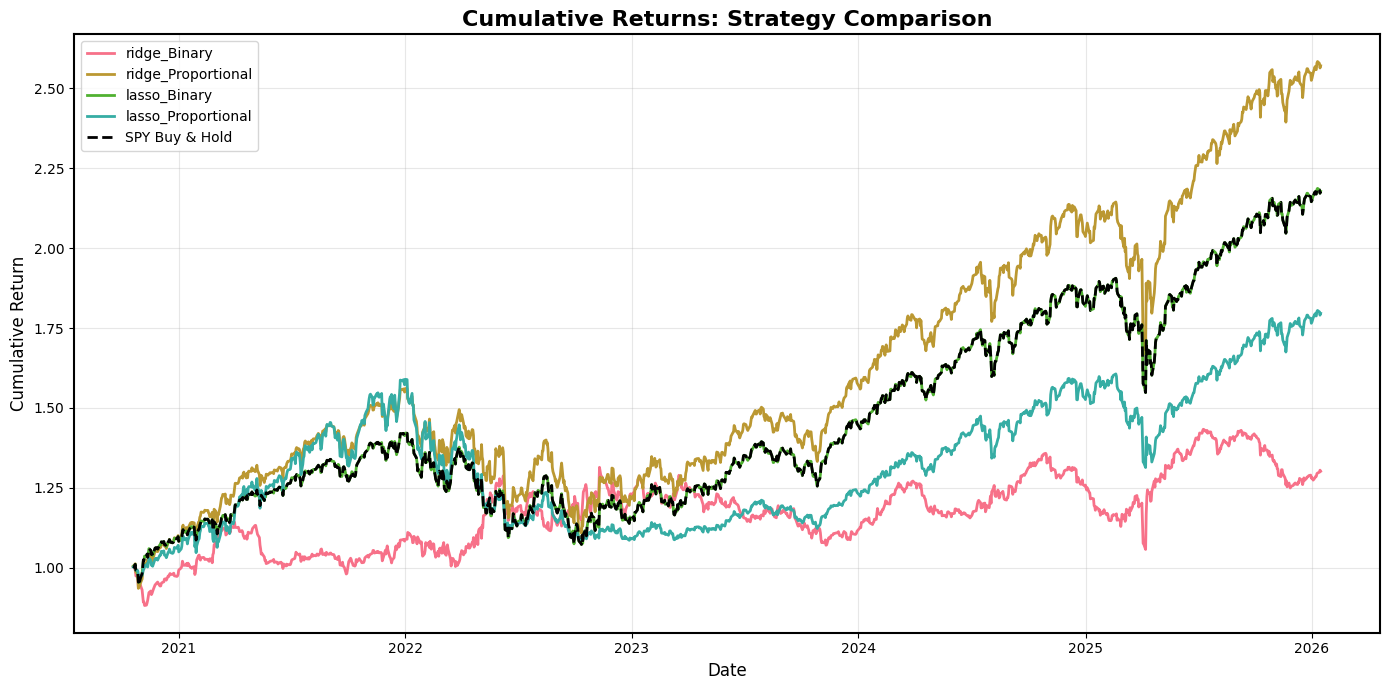

📈 Cumulative returns plotted!


In [10]:
# Plot cumulative returns
fig, ax = plt.subplots(figsize=(14, 7))

for i, (regout, tag) in enumerate(zip(regout_list, sweep_tags)):
    if 'perf_ret' in regout.columns:
        cumulative = np.exp(regout['perf_ret'].cumsum())
        ax.plot(cumulative.index, cumulative.values, label=tag, linewidth=2)

# Add SPY benchmark
spy_cumulative = np.exp(y.loc[regout_list[0].index].cumsum())
ax.plot(spy_cumulative.index, spy_cumulative.values, 
        label='SPY Buy & Hold', color='black', linestyle='--', linewidth=2)

ax.set_title('Cumulative Returns: Strategy Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📈 Cumulative returns plotted!")

## 9. Summary and Next Steps

### Key Takeaways

1. **Walk-Forward Validation**: We prevented look-ahead bias by training only on historical data
2. **Position Sizing**: Different strategies can significantly impact returns and risk
3. **Benchmarking**: Professional comparison is essential for evaluating alpha generation
4. **Performance Metrics**: Sharpe ratio, drawdowns, and volatility are key indicators

### Next Steps

1. Try different machine learning models (RandomForest, XGBoost, etc.)
2. Experiment with feature engineering (momentum, volatility, etc.)
3. Test different position sizing strategies
4. Move to multi-target strategies (see `02_multi_target_tutorial.ipynb`)
5. Implement risk management (stop-losses, position limits)

### Resources

- Project README: `../README.md`
- Documentation: `../docs/`
- Source code: `../src/`

In [11]:
print("\n" + "="*80)
print("🎉 Tutorial Complete!")
print("="*80)
print(f"\nStrategies tested: {len(sweep_tags)}")
print(f"Best strategy: {best_strategy}")
print(f"\nNext: Check out the multi-target tutorial for more advanced strategies!")
print("="*80)


🎉 Tutorial Complete!

Strategies tested: 4
Best strategy: ridge_Proportional

Next: Check out the multi-target tutorial for more advanced strategies!
